# Chapter 2: Routing

라우팅은 에이전트의 운영 프레임워크에 조건 기반 논리를 도입함으로써, 고정된 실행 경로에서 벗어나 에이전트가 특정 기준을 동적으로 평가해서 다음 가능한 행동들 중 하나를 선택하는 모델로 바뀌게 한다.

라우팅 패턴의 핵심 컴포넌트는 평가를 수행하고 흐름을 제어하는 메커니즘이다. 여러가지로 구현될 수 있다

- LLM-based Routing : LLM에게 입력을 분석하고 다음 단계를 지시하는 명령을 출력하도록 프롬프팅
- Embedding-based Routing : 입력 쿼리가 벡터 임베딩으로 변환되고 미리 정의한 경로의 임베딩 들과 유사도 비교로 라우팅
- Rule-based Routing : 미리 정의한 규칙이나 로직을 사용해서 입력을 분류
- Machine Learning Model-Based Routing : 작은 라벨링 데이터로 학습된 판별 모델(분류기)을 사용해서 라우팅

라우팅은 에이전트 플로우에서 결정이 필요한 모든 지점에 삽입될 수 있음.
- 초기 : 작업 분류용 
- 중간 :  다음 단계 선택용
- 후반 : 도구 결정용


In [1]:
from typing_extensions import TypedDict
from typing import Optional, Literal, Dict, Any

from langgraph.graph import StateGraph, START, END
from llm import LocalLLM # LLM 클라이언트 임포트

In [2]:
# 상태 타입 정의
class State(TypedDict, total=False):
    request: str # 사용자 요청
    decision: Literal["booker", "info", "unclear"] # 라우팅 결정
    output: str # 최종 출력 ( 핸들러 결과 )


llm = LocalLLM()

# Router 노드 ( LLM-Based Routing)
def router_node(state: State) -> State:
    req = state["request"]
    messages = [
        {
            "role": "system",
            "content": (
                "당신은 라우팅 분류기입니다. 사용자의 요청을 보고 반드시 소문자 한 단어만 출력하세요:\n"
                "`booker`, `info, 또는 `unclear`.\n"
                "- 항공권/호텔 등 예약 관련이면 -> booker\n"
                "- 일반 정보 질문이면 -> info\n"
                "- 그 외이거나 애매하면 -> unclear\n"
                "출력 형식: booker | info | unclear (이 중 하나만)."
            ),
        },
        {"role": "user", "content": req},
    ]
    decision_raw = llm.chat(messages=messages, reasoning=False)
    decision = decision_raw.strip().lower()

    # 기대값이 아니면, unclear로 처리
    if decision not in ("booker", "info", "unclear"):
        decision = "unclear"

    state["decision"] = decision
    return state

# 분기(핸들러) 노드
def booking_handler(state: State) -> State:
    req = state["request"]
    print("\n[Booker] 처리 중...", flush=True)
    state["output"] = f"예약 처리 완료: {req}"
    return state

def info_handler(state: State) -> State:
    req = state["request"]
    print("\n[Info] 처리 중...", flush=True)

    messages = [
        {"role": "system", "content": "너는 도움을 주는 비서야. 한국어로 간단명료하게 답해."},
        {"role": "user", "content": req},
    ]
    answer = llm.chat(messages=messages, reasoning=True)
    state["output"] = answer
    return state

def unclear_handler(state: State) -> State:
    req = state["request"]
    print("\n[Unclear] 처리 중...", flush=True)
    state["output"] = f"요청을 분류하지 못했습니다: '{req}'\n조금 더 구체적으로 말씀해 주세요."
    return state

In [3]:
graph = StateGraph(State)

graph.add_node("router", router_node)
graph.add_node("booker", booking_handler)
graph.add_node("info", info_handler)
graph.add_node("unclear", unclear_handler)

graph.add_edge(START, "router")

# router의 decision에 따른 조건부 분기
graph.add_conditional_edges(
    "router",
    lambda s: s["decision"], # `booker` | `info` | `unclear`
    {
        "booker": "booker",
        "info": "info",
        "unclear": "unclear",
    }
)

graph.add_edge("booker", END)
graph.add_edge("info", END)
graph.add_edge("unclear", END)

app = graph.compile()

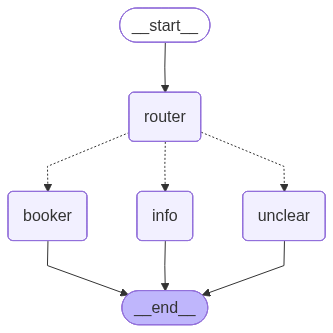

In [4]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [5]:
final = app.invoke({"request": "서울에서 뉴욕까지 가는 항공권 예약해줘."})
print(f"최종 출력: {final.get("decision")}")
print(f"핸들러 결과: {final.get("output")}")


[Booker] 처리 중...
최종 출력: booker
핸들러 결과: 예약 처리 완료: 서울에서 뉴욕까지 가는 항공권 예약해줘.


In [6]:
final = app.invoke({"request": "파리의 유명한 관광지는 어디야?"})
print(f"최종 출력: {final.get("decision")}")
print(f"핸들러 결과: {final.get("output")}")


[Info] 처리 중...
최종 출력: info
핸들러 결과: 파리의 유명한 관광지는 다음과 같아요:  
1. **에菲尔타워** - 최고의 상징.  
2. **루브르미술관** - 라라라 미니어처, 몬나리사 등.  
3. **노트르담대성당** - 중세 건축의 대표.  
4. **사크레-코르 대성당** - 몽마르트 위에 위치.  
5. **세인트-日内아 대성당** - 쇼를 코르네리에.  
6. **노트르담 플라자** - 거대한 광장.  
7. **루브르 광장** - 미술관 인근.  
8. **팔레트 드 빅** - 왕실의 거대한 궁전.  

이 곳들은 파리의 정체성과 역사가 담겨 있어 추천해요!


In [7]:
final = app.invoke({"request": "?@#$%^&*()"})
print(f"최종 출력: {final.get("decision")}")
print(f"핸들러 결과: {final.get("output")}")


[Unclear] 처리 중...
최종 출력: unclear
핸들러 결과: 요청을 분류하지 못했습니다: '?@#$%^&*()'
조금 더 구체적으로 말씀해 주세요.


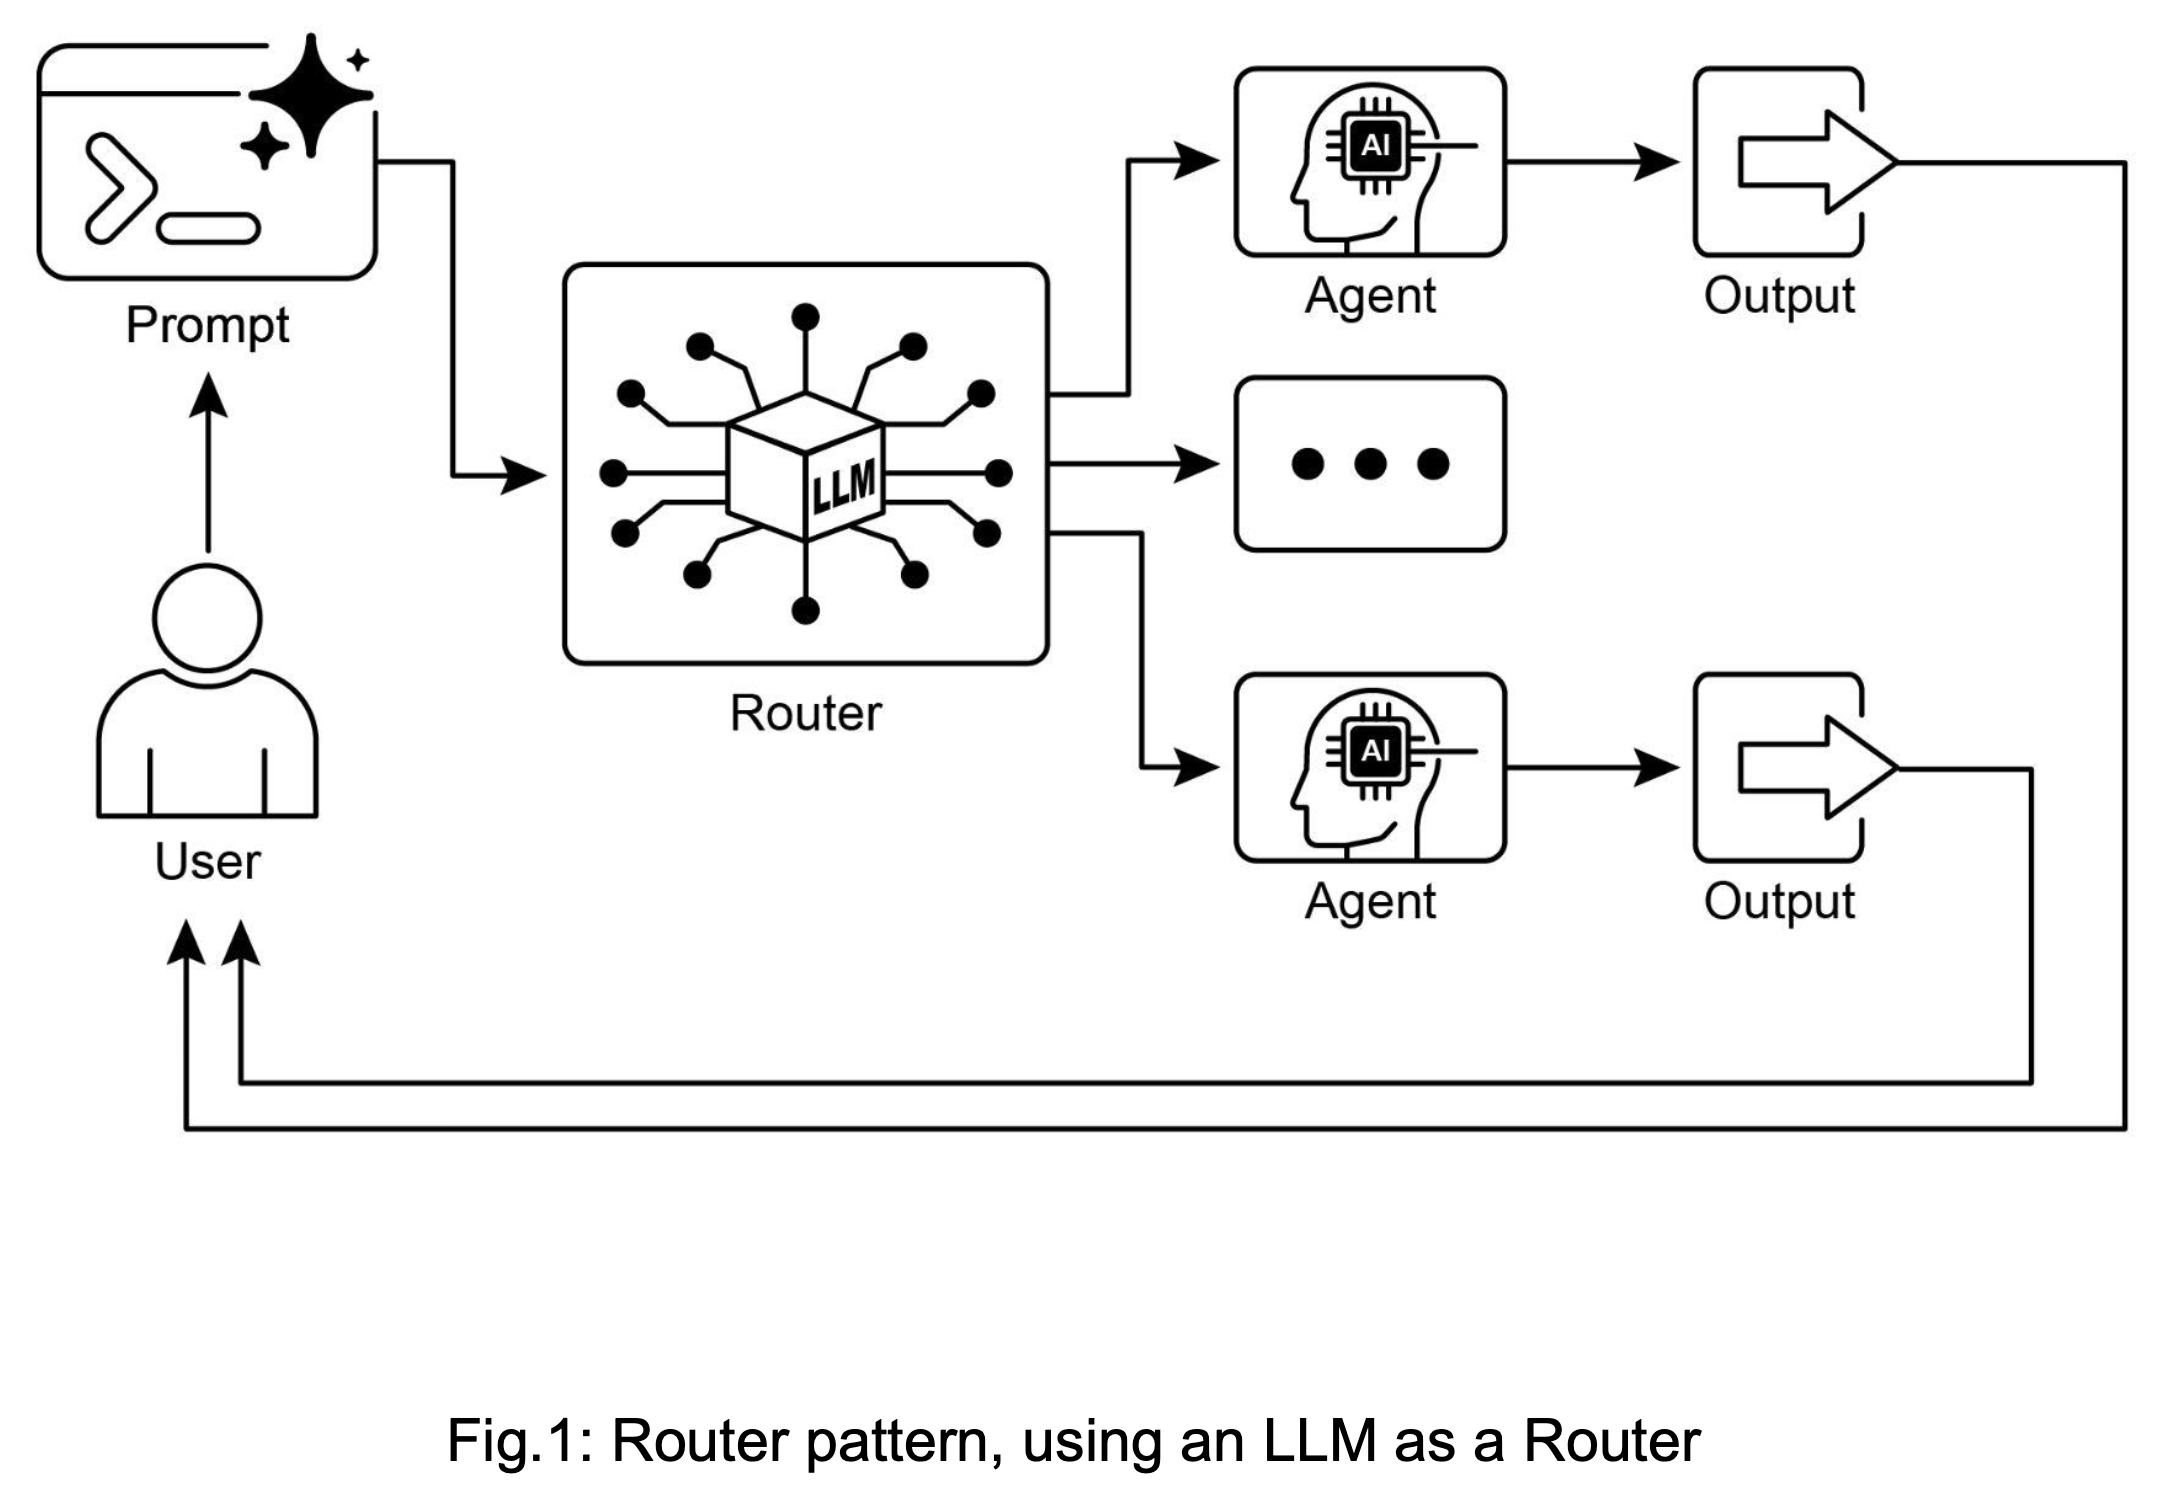

라우팅 패턴은, 다양한 시나리오를 지능적으로 탐색하고 문맥에 기반한 맞춤형 응답을 제공하는 에이전트를 구축하는데 필수적이다.

# Hierarchical routing

In [8]:
from typing import Annotated
from typing_extensions import TypedDict,  Literal
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.output_parsers import PydanticOutputParser
from llm import LocalLLM

class State(TypedDict):
    query: str
    categories: str
    login_type: str
    response: str

class Categories(BaseModel):
    categories: Literal["LOGIN_ASSISTANT", "CARD_ASSISTANT", "DEFAULT_ASSISTANT"] = Field(
        description="쿼리에 해당하는 모든 카테고리"
    )

class LoginType(BaseModel):
    login_type: Literal["FIRST_LOGIN", "EXISTING_LOGIN"] = Field(
        description="쿼리에 해당하는 모든 로그인 유형"
    )

In [9]:
llm = LocalLLM()


def router(state: State):
    system_prompt = """
    당신은 분류기로 사용자의 쿼리를 분석하여 적절한 카테고리와 로그인 유형을 결정합니다.

    - LOGIN_ASSISTANT: 로그인 문제 해결 관련 쿼리
    - CARD_ASSISTANT: 카드 문제 해결 관련 쿼리
    - DEFAULT_ASSISTANT: 기타 일반 쿼리

    카테고리를 JSON 형식으로 출력하세요.
    { "categories": ["CATEGORY1", "CATEGORY2"] }
    관련 있는 카테고리만 포함하세요.
    """

    router_chain = llm.with_structured_output(Categories)

    response = router_chain.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(content=state["query"])
    ])

    print(response)
    return {"categories": response.categories}


def route_to_assistant(state: State) -> list[str]:
    return state["categories"]

In [15]:
def route_to_assistant(state: State):
    return state["categories"]

def login_assistant(state: State):
    system_prompt = """
    당신은 분류기로 사용자 쿼리를 분석해서 사용자가 처음 로그인하는지 아니면 기존 사용자 로그인 문제인지 결정합니다.

    FIRST_LOGIN: 처음 로그인하는 사용자
    EXISTING_LOGIN: 기존 사용자 로그인 문제

    위 카테고리 중 하나만 반환 하세요.
    """

    router_chain = llm.with_structured_output(LoginType)
    response = router_chain.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(content=state["query"])
    ])

    print(response)
    return {"login_type": response.login_type}

def route_to_login_assistant(state: State):
    return state["login_type"]

def first_login_assistant(state: State):
    return {"response": "안녕하세요 처음 로그인 도우미입니다. 어떻게 도와드릴까요?"}

def existing_login_assistant(state: State):
    return {"response": "안녕하세요 기존 로그인 도우미입니다. 어떻게 도와드릴까요?"}

def card_assistant(state: State):
    return {"response": "안녕하세요 카드 도우미입니다. 어떻게 도와드릴까요?"}

def default_assistant(state: State):
    return {"response": "안녕하세요 일반 도우미입니다. 어떻게 도와드릴까요?"}

In [16]:
graph = StateGraph(State)

graph.add_node("router", router)
graph.add_node("login_assistant", login_assistant)
graph.add_node("first_login_assistant", first_login_assistant)
graph.add_node("existing_login_assistant", existing_login_assistant)
graph.add_node("card_assistant", card_assistant)
graph.add_node("default_assistant", default_assistant)

graph.add_edge(START, "router")
graph.add_conditional_edges(
    "router",
    route_to_assistant,
    {
        "LOGIN_ASSISTANT": "login_assistant",
        "CARD_ASSISTANT": "card_assistant",
        "DEFAULT_ASSISTANT": "default_assistant",
    }
)

graph.add_conditional_edges(
    "login_assistant",
    route_to_login_assistant,
    {
        "FIRST_LOGIN": "first_login_assistant",
        "EXISTING_LOGIN": "existing_login_assistant",
    }
)
graph.add_edge("login_assistant", END)
graph.add_edge("card_assistant", END)
graph.add_edge("default_assistant", END)
app = graph.compile()

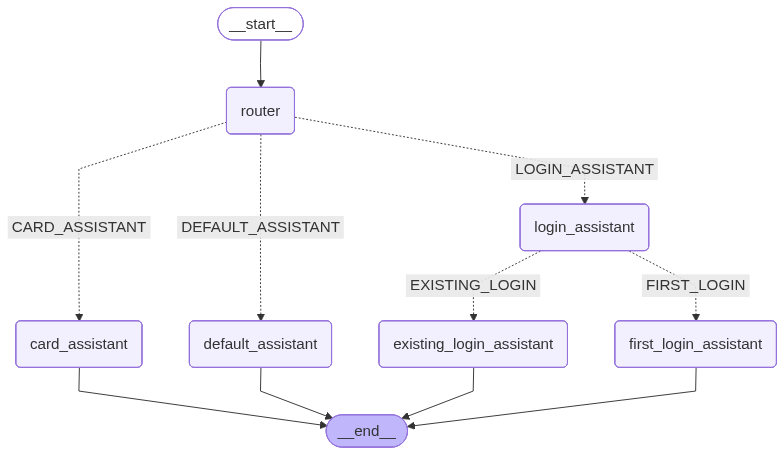

In [17]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [19]:
output = app.invoke(
    {"query": "처음 로그인하는데 도움이 필요해요."}
)
display(output)

categories='LOGIN_ASSISTANT'
login_type='FIRST_LOGIN'


{'query': '처음 로그인하는데 도움이 필요해요.',
 'categories': 'LOGIN_ASSISTANT',
 'login_type': 'FIRST_LOGIN',
 'response': '안녕하세요 처음 로그인 도우미입니다. 어떻게 도와드릴까요?'}